In [3]:
import pandas as pd
import numpy as np
from collections import Counter
import random
import re

# Load data into DataFrames
original_df = pd.read_csv('logs_data.csv')

# Drop 'complexity' column if exists
if 'complexity' in original_df.columns:
    original_df.drop(columns=['complexity'], inplace=True)

# Function to extract entity placeholders and generate variations
def generate_log_variation(log_msg):
    user_match = re.search(r'user\s+(\w+)', log_msg, re.IGNORECASE)
    ip_match = re.search(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b', log_msg)
    file_match = re.search(r'file\s+[^\s]+', log_msg, re.IGNORECASE)

    if user_match:
        log_msg = re.sub(r'user\s+\w+', f"user {random.choice(['u123', 'u803', 'x456', 'x650', 'a789', 'a109', 'z999', 'z509'])}", log_msg)
    if ip_match:
        log_msg = re.sub(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b', f"{random.randint(10, 255)}.{random.randint(0, 255)}.{random.randint(0, 255)}.{random.randint(0, 255)}", log_msg)
    if file_match:
        log_msg = re.sub(r'file\s+[^\s]+', f"file {random.choice(['/etc/passwd', '/var/log/syslog', '/usr/bin/script.sh'])}", log_msg)

    return log_msg

# Stratified sampling to maintain distribution
target_counts = original_df['target_label'].value_counts(normalize=True)
source_counts = original_df['source'].value_counts(normalize=True)

# Generate synthetic data
n_samples = 5000
synthetic_logs = []

for _ in range(n_samples):
    target_label = np.random.choice(target_counts.index, p=target_counts.values)
    source = np.random.choice(source_counts.index, p=source_counts.values)
    sample_logs = original_df[
        (original_df['target_label'] == target_label) & 
        (original_df['source'] == source)
    ]
    if sample_logs.empty:
        sample_logs = original_df[original_df['target_label'] == target_label]
    row = sample_logs.sample(n=1).iloc[0]
    
    synthetic_logs.append({
        'timestamp': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        'source': source,
        'log_message': generate_log_variation(row['log_message']),
        'target_label': target_label
    })

# Convert to DataFrame
synthetic_logs_df = pd.DataFrame(synthetic_logs)
synthetic_logs_df.head()


,timestamp,source,log_message,target_label
0,2025-05-18 00:53:30,BillingSystem,User User409 logged out.,User Action
1,2025-05-18 00:53:30,ModernCRM,Warning: potential password cracking attempt f...,Security Alert
2,2025-05-18 00:53:30,BillingSystem,System updated to version 4.0.3.,System Notification
3,2025-05-18 00:53:30,BillingSystem,nova.osapi_compute.wsgi.server [req-0faa8465-e...,HTTP Status
4,2025-05-18 00:53:30,BillingSystem,SSL certificate issue caused service health ch...,Error


In [7]:
# Drop duplicate rows based on source, log_message, and target_label — keep one
deduplicated_synthetic_logs_df = synthetic_logs_df.drop_duplicates(
    subset=["source", "log_message", "target_label"],
    keep="first"  # keep only one occurrence
).reset_index(drop=True)

print(f"Original synthetic logs: {len(synthetic_logs_df)}")
print(f"Deduplicated synthetic logs: {len(deduplicated_synthetic_logs_df)}")


Original synthetic logs: 5000
Deduplicated synthetic logs: 3462


In [8]:
# 1. Concatenate the two dataframes (combine rows)
combined_df = pd.concat([original_df, deduplicated_synthetic_logs_df], ignore_index=True)

# 2. Check duplicates on the subset and drop them (keep first occurrence)
final_df = combined_df.drop_duplicates(subset=["source", "log_message", "target_label"], keep='first')

print(f"Original rows after concat: {len(combined_df)}")
print(f"Rows after dropping duplicates: {len(final_df)}")

generated_df = final_df

# Convert to NumPy arrays
original_data = original_df.to_numpy()
generated_data = generated_df.to_numpy()

Original rows after concat: 5872
Rows after dropping duplicates: 4887


In [9]:
# Shape comparison
print("Original shape:", original_data.shape)
print("Generated shape:", generated_data.shape)
print()
# Check columns match
print("Original columns:", original_df.columns.tolist())
print("Generated columns:", generated_df.columns.tolist())
print()
# Check unique values in target label and source
print("Original targets:", original_df['target_label'].unique())
print("Generated targets:", generated_df['target_label'].unique())
print()
print("Original sources:", original_df['source'].unique())
print("Generated sources:", generated_df['source'].unique())


Original shape: (2410, 4)
Generated shape: (4887, 4)

Original columns: ['timestamp', 'source', 'log_message', 'target_label']
Generated columns: ['timestamp', 'source', 'log_message', 'target_label']

Original targets: ['HTTP Status' 'Critical Error' 'Security Alert' 'Error'
 'System Notification' 'Resource Usage' 'User Action' 'Workflow Error'
 'Deprecation Warning']
Generated targets: ['HTTP Status' 'Critical Error' 'Security Alert' 'Error'
 'System Notification' 'Resource Usage' 'User Action' 'Workflow Error'
 'Deprecation Warning']

Original sources: ['ModernCRM' 'AnalyticsEngine' 'ModernHR' 'BillingSystem' 'ThirdPartyAPI'
 'LegacyCRM']
Generated sources: ['ModernCRM' 'AnalyticsEngine' 'ModernHR' 'BillingSystem' 'ThirdPartyAPI'
 'LegacyCRM']


In [10]:
# Full row duplicates
original_dups = original_df.duplicated().sum()
generated_dups = generated_df.duplicated().sum()

# Duplicates based on log_message only
original_msg_dups = original_df.duplicated(subset=['log_message']).sum()
generated_msg_dups = generated_df.duplicated(subset=['log_message']).sum()

print(f"Original - Full Duplicates: {original_dups}, Log Message Duplicates: {original_msg_dups}")
print(f"Generated - Full Duplicates: {generated_dups}, Log Message Duplicates: {generated_msg_dups}")


Original - Full Duplicates: 0, Log Message Duplicates: 145
Generated - Full Duplicates: 0, Log Message Duplicates: 116


In [11]:
original_df['target_label'].value_counts()

target_label
HTTP Status            1017
Security Alert          371
System Notification     356
Error                   177
Resource Usage          177
Critical Error          161
User Action             144
Workflow Error            4
Deprecation Warning       3
Name: count, dtype: int64

In [12]:
generated_df['target_label'].value_counts()

target_label
HTTP Status            3143
Security Alert          685
System Notification     390
Error                   177
Resource Usage          165
Critical Error          162
User Action             144
Deprecation Warning      11
Workflow Error           10
Name: count, dtype: int64

In [13]:
original_df['source'].value_counts()

source
ThirdPartyAPI      496
ModernHR           492
BillingSystem      479
AnalyticsEngine    471
ModernCRM          465
LegacyCRM            7
Name: count, dtype: int64

In [14]:
generated_df['source'].value_counts()

source
ThirdPartyAPI      1040
AnalyticsEngine     980
ModernHR            963
ModernCRM           946
BillingSystem       939
LegacyCRM            19
Name: count, dtype: int64

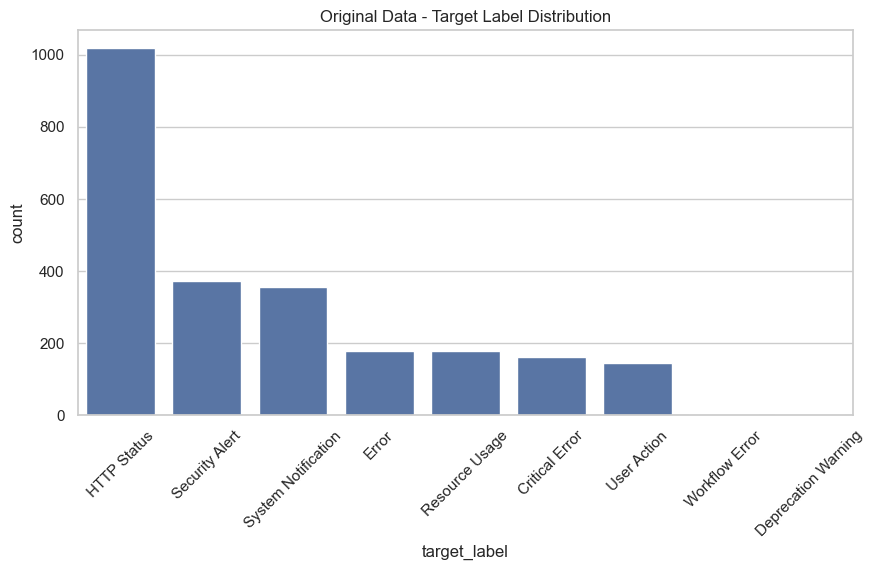

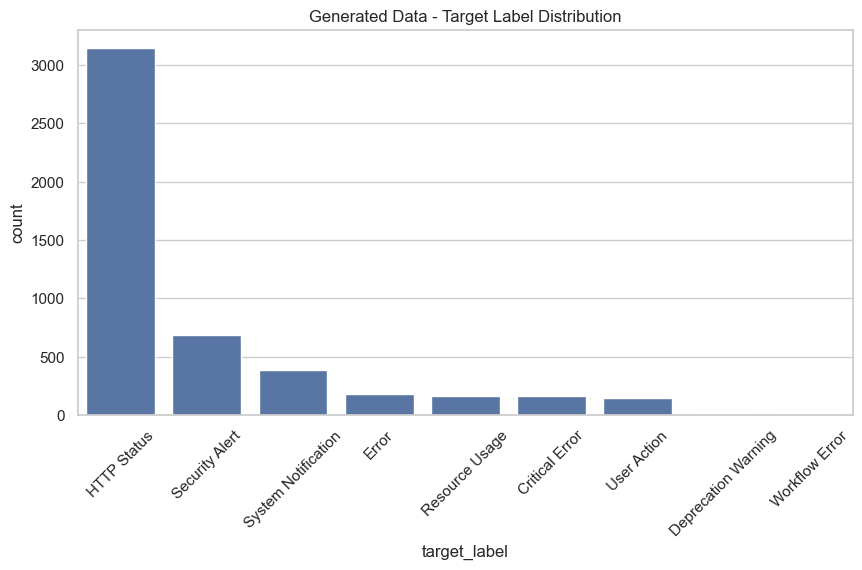

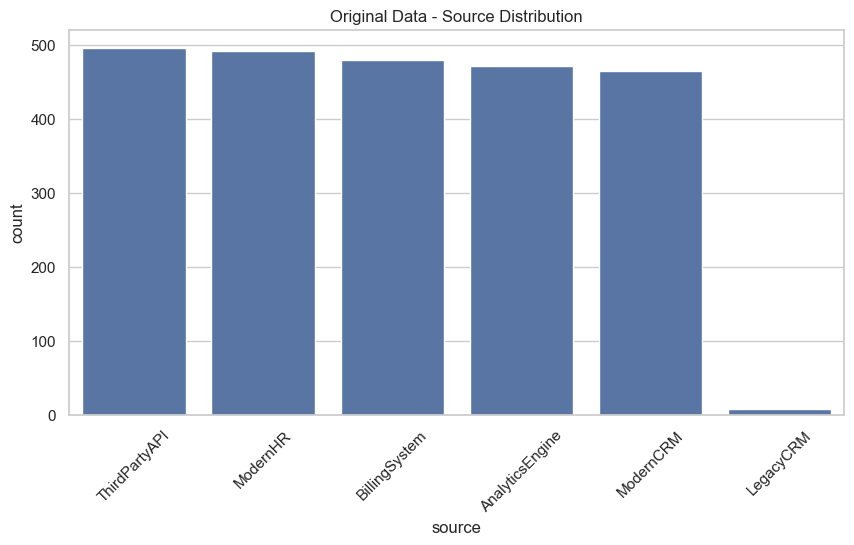

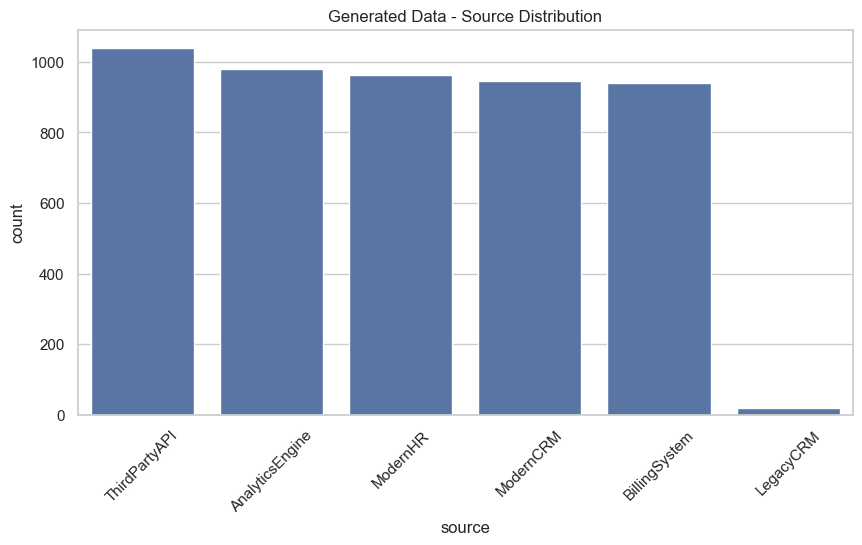

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot target_label distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=original_df, x='target_label', order=original_df['target_label'].value_counts().index)
plt.title("Original Data - Target Label Distribution")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=generated_df, x='target_label', order=generated_df['target_label'].value_counts().index)
plt.title("Generated Data - Target Label Distribution")
plt.xticks(rotation=45)
plt.show()

# Plot source distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=original_df, x='source', order=original_df['source'].value_counts().index)
plt.title("Original Data - Source Distribution")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=generated_df, x='source', order=generated_df['source'].value_counts().index)
plt.title("Generated Data - Source Distribution")
plt.xticks(rotation=45)
plt.show()

In [16]:
generated_df[(generated_df['source'] != 'LegacyCRM') & (generated_df['target_label'] == 'Workflow Error')]

,timestamp,source,log_message,target_label
3426,2025-05-18 00:53:30,ThirdPartyAPI,Task assignment for TeamID 3425 could not comp...,Workflow Error
3455,2025-05-18 00:53:30,AnalyticsEngine,Customer follow-up process for lead ID 5621 fa...,Workflow Error
4264,2025-05-18 00:53:30,ModernHR,Task assignment for TeamID 3425 could not comp...,Workflow Error
5338,2025-05-18 00:53:31,ModernHR,Customer follow-up process for lead ID 5621 fa...,Workflow Error
5495,2025-05-18 00:53:31,BillingSystem,Customer follow-up process for lead ID 5621 fa...,Workflow Error
5551,2025-05-18 00:53:31,ModernCRM,Customer follow-up process for lead ID 5621 fa...,Workflow Error


In [19]:
generated_df[(generated_df['source'] != 'LegacyCRM') & (generated_df['target_label'] == 'Deprecation Warning')]

,timestamp,source,log_message,target_label
2665,2025-05-18 00:53:30,ModernCRM,API endpoint 'getCustomerDetails' is deprecate...,Deprecation Warning
2940,2025-05-18 00:53:30,ThirdPartyAPI,Support for legacy authentication methods will...,Deprecation Warning
3074,2025-05-18 00:53:30,AnalyticsEngine,The 'ExportToCSV' feature is outdated. Please ...,Deprecation Warning
3076,2025-05-18 00:53:30,AnalyticsEngine,API endpoint 'getCustomerDetails' is deprecate...,Deprecation Warning
3318,2025-05-18 00:53:30,ModernHR,The 'ExportToCSV' feature is outdated. Please ...,Deprecation Warning
3936,2025-05-18 00:53:31,ModernCRM,Support for legacy authentication methods will...,Deprecation Warning
4238,2025-05-18 00:53:31,ModernHR,Support for legacy authentication methods will...,Deprecation Warning
4747,2025-05-18 00:53:31,BillingSystem,The 'ExportToCSV' feature is outdated. Please ...,Deprecation Warning


In [21]:
generated_df = generated_df[~((generated_df['source'] != 'LegacyCRM') & (generated_df['target_label'].isin(['Workflow Error', 'Deprecation Warning'])))]
generated_df.reset_index(drop=True, inplace=True)

In [22]:
# write out as CSV
generated_df.to_csv('./Dataset/synthetic_logs.csv', index=False)